<a href="https://colab.research.google.com/github/selfor21/NN-Models/blob/main/06_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VARIATIONAL AUTO ENCODER - VAE



## Generative Models

Neural Network Models de Redes Neurais able to generate new examples from training, e.g., VAE e GAN

### Variational Autoencoders (VAE):

- Autoencoder that learns a latent distribution p(z|x) instead the unique latent structure.

https://blog.keras.io/building-autoencoders-in-keras.html


## Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras.datasets as kds

import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas utilizadas para projeção / redução de dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA

## Data Loading (MNIST)

### MNIST-Fashion

https://en.wikipedia.org/wiki/MNIST_database

https://keras.io/api/datasets/mnist/


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png">



In [ ]:
num_classes = 10
input_shape = (28, 28, 1)

# Carga dos dados (keras.datasets)
(x_train, y_train), (x_test, y_test) = kds.mnist.load_data()

# Normalização das features
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


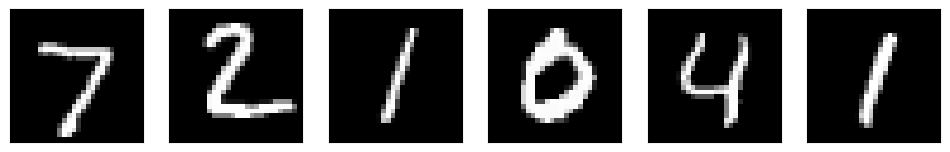

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Autoencoder Variacional 01




## Definição do Modelo

In [ ]:
# Função de amostragem
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

original_dim = 784 # 28x28
latent_dim = 2

In [ ]:
# Definição do encoder
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder01 = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [ ]:
# Definição do decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder01 = keras.Model(latent_inputs, outputs, name='decoder')

In [ ]:
# Criação do VAE
outputs = decoder01(encoder01(inputs)[2]) # decoder recebe z como entrada (saída 2 do encoder)
vae01 = keras.Model(inputs, outputs, name='vae_mlp')
vae01.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               50500     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               51152     
                                                                 
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


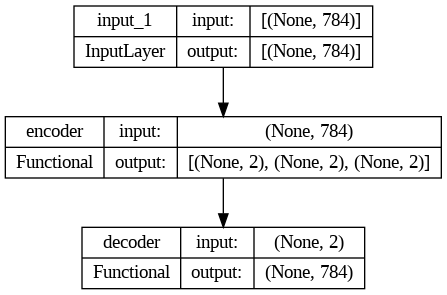

In [ ]:
tf.keras.utils.plot_model(vae01, show_shapes=True)

## Função de Custo

---



In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae01.add_loss(vae_loss)

## Treinamento do Autoencoder 01

In [ ]:
vae01.compile(optimizer='adam')

history = vae01.fit(x_train, x_train,
                    epochs=200,
                    batch_size=256,
                    validation_data=(x_test, x_test),
                    verbose=1)

Epoch 1/200
235/235 [==============================] - 13s 17ms/step - loss: 256.2151 - val_loss: 194.9300
Epoch 2/200
235/235 [==============================] - 2s 10ms/step - loss: 184.7168 - val_loss: 177.5678
Epoch 3/200
235/235 [==============================] - 3s 11ms/step - loss: 174.5297 - val_loss: 170.7272
Epoch 4/200
235/235 [==============================] - 2s 10ms/step - loss: 169.3386 - val_loss: 167.8239
Epoch 5/200
235/235 [==============================] - 3s 13ms/step - loss: 167.1638 - val_loss: 166.2789
Epoch 6/200
235/235 [==============================] - 4s 15ms/step - loss: 165.7953 - val_loss: 165.3286
Epoch 7/200
235/235 [==============================] - 1s 6ms/step - loss: 164.7184 - val_loss: 164.3572
Epoch 8/200
235/235 [==============================] - 1s 5ms/step - loss: 163.8211 - val_loss: 163.6985
Epoch 9/200
235/235 [==============================] - 1s 5ms/step - loss: 163.0252 - val_loss: 162.9201
Epoch 10/200
235/235 [==========================

## Avaliação

313/313 [==============================] - 1s 2ms/step


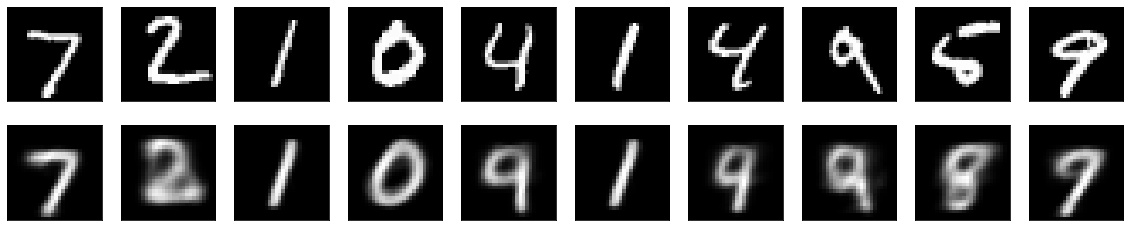

In [ ]:
decoded_imgs01 = vae01.predict(x_test)

n = 10  # Imagens visualizadas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrução
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs01[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

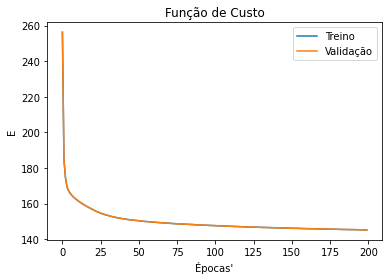

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()


### Visualização do Espaço Latente

40/40 [==============================] - 0s 3ms/step


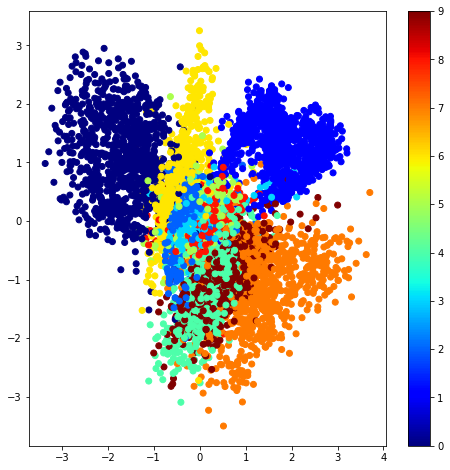

In [ ]:
x_test_encoded = encoder01.predict(x_test, batch_size=256)[2]

plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

## Reconstrução Amostra

1/1 [==============================] - 0s 26ms/step


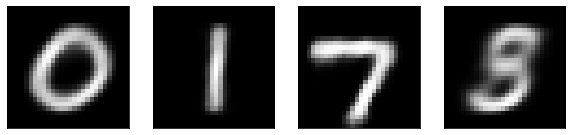

In [ ]:
sampled = np.array([[-2,1],   
                    [2,1],  
                    [2,-2],    
                    [0,0]])


rec = decoder01.predict(sampled) 

plt.figure(figsize=(10, 4))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(rec[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Ilustração do espaço latente

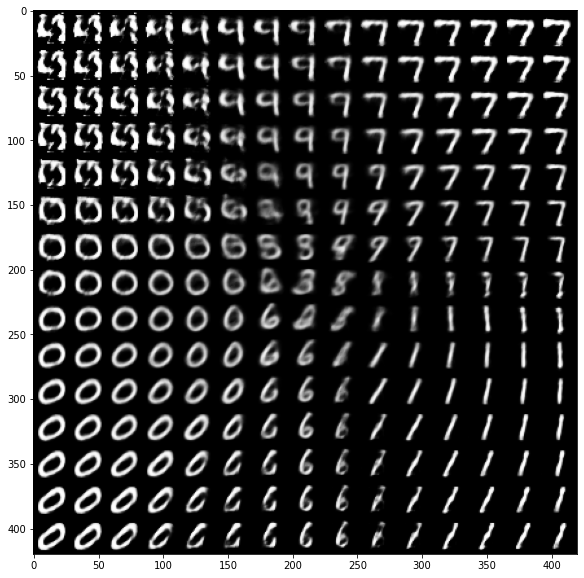

In [ ]:
n = 15  
figure = np.zeros((28 * n, 28 * n))
grid_x = np.linspace(np.min(x_test_encoded[:, 0]), np.max(x_test_encoded[:, 0]), n)
grid_y = np.linspace(np.min(x_test_encoded[:, 1]), np.max(x_test_encoded[:, 1]), n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder01.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Autoencoder Variacional 02
## Sem a Divergência KL




## Definição do Modelo

In [ ]:
# Definição do encoder
inputs02 = keras.Input(shape=(original_dim,))
h02 = layers.Dense(64, activation='relu')(inputs02)
z_mean02 = layers.Dense(latent_dim)(h02)
z_log_sigma02 = layers.Dense(latent_dim)(h02)
z02 = layers.Lambda(sampling)([z_mean02, z_log_sigma02])
encoder02 = keras.Model(inputs02, [z_mean02, z_log_sigma02, z02], name='encoder')

In [ ]:
# Definição do decoder
latent_inputs02 = keras.Input(shape=(latent_dim,), name='z_sampling')
x02 = layers.Dense(64, activation='relu')(latent_inputs02)
outputs02 = layers.Dense(original_dim, activation='sigmoid')(x02)
decoder02 = keras.Model(latent_inputs02, outputs02, name='decoder')

In [ ]:
# Criação do VAE
outputs02 = decoder02(encoder02(inputs02)[2]) # decoder recebe z como entrada (saída 2 do encoder)
vae02 = keras.Model(inputs02, outputs02, name='vae_mlp')
vae02.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               50500     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               51152     
                                                                 
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


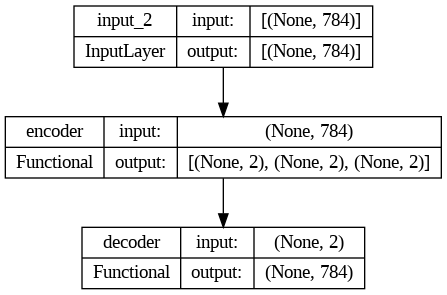

In [ ]:
tf.keras.utils.plot_model(vae02, show_shapes=True)

## Função de Custo

---



In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs02, outputs02)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma02 - K.square(z_mean02) - K.exp(z_log_sigma02)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.0*kl_loss)
vae02.add_loss(vae_loss)

## Treinamento do Autoencoder

In [ ]:
vae02.compile(optimizer='adam')

history = vae02.fit(x_train, x_train,
                    epochs=200,
                    batch_size=256,
                    validation_data=(x_test, x_test),
                    verbose=0)

## Avaliação

313/313 [==============================] - 1s 2ms/step


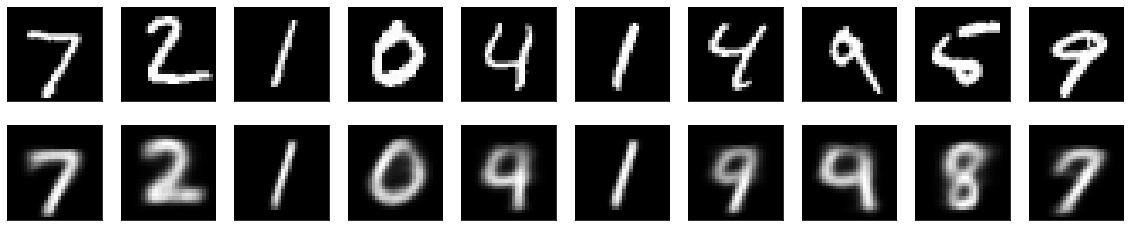

In [ ]:
decoded_imgs02 = vae02.predict(x_test)

n = 10  # Imagens visualizadas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrução
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs02[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

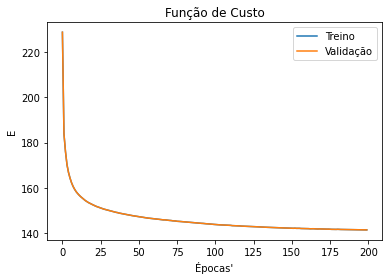

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()


### Visualização do Espaço Latente


40/40 [==============================] - 0s 2ms/step


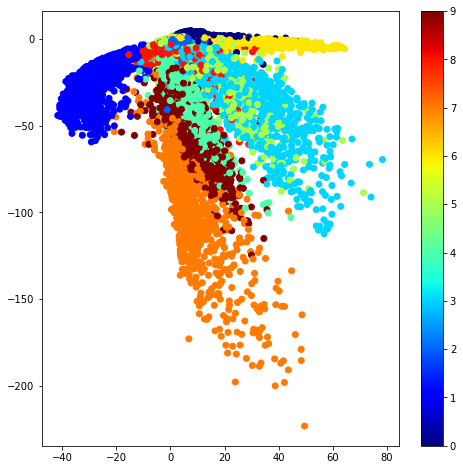

In [ ]:
x_test_encoded2 = encoder02.predict(x_test, batch_size=256)[2]

plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded2[:, 0], x_test_encoded2[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

## Reconstrução Amostra

## Ilustração do espaço latente

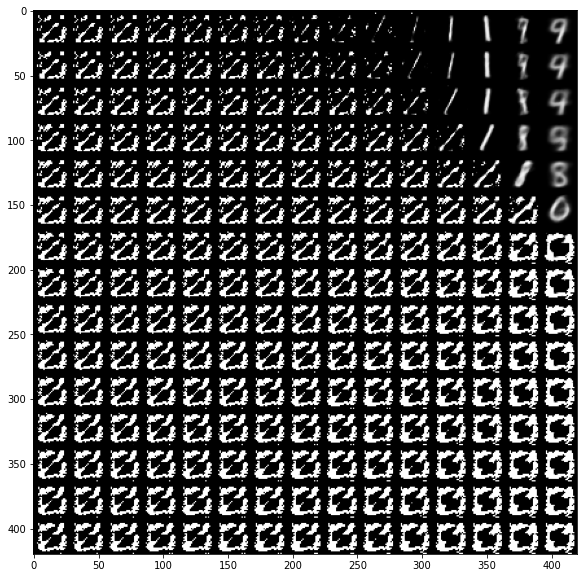

In [ ]:
n = 15  
figure = np.zeros((28 * n, 28 * n))
grid_x = np.linspace(np.min(x_test_encoded2[:, 0]), np.max(x_test_encoded2[:, 0]), n)
grid_y = np.linspace(np.min(x_test_encoded2[:, 1]), np.max(x_test_encoded2[:, 1]), n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder02.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Autoencoder Variacional 03

### Espaço latente com mais dimensões (>2)




## Definição do Modelo

In [ ]:
latent_dim = 4

# Definição do encoder
inputs03 = keras.Input(shape=(original_dim,))
h03 = layers.Dense(128, activation='relu')(inputs03)
h03 = layers.Dense(64, activation='relu')(h03)
z_mean03 = layers.Dense(latent_dim)(h03)
z_log_sigma03 = layers.Dense(latent_dim)(h03)
z03 = layers.Lambda(sampling)([z_mean03, z_log_sigma03])
encoder03 = keras.Model(inputs03, [z_mean03, z_log_sigma03, z03], name='encoder')

In [ ]:
# Definição do decoder
latent_inputs03 = keras.Input(shape=(latent_dim,), name='z_sampling')
x03 = layers.Dense(64, activation='relu')(latent_inputs03)
x03 = layers.Dense(128, activation='relu')(x03)
outputs03 = layers.Dense(original_dim, activation='sigmoid')(x03)
decoder03 = keras.Model(latent_inputs03, outputs03, name='decoder')

In [ ]:
# Criação do VAE
outputs03 = decoder03(encoder03(inputs03)[2]) # decoder recebe z como entrada (saída 2 do encoder)
vae03 = keras.Model(inputs03, outputs03, name='vae_mlp')
vae03.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 4),               109256    
                              (None, 4),                         
                              (None, 4)]                         
                                                                 
 decoder (Functional)        (None, 784)               109776    
                                                                 
Total params: 219,032
Trainable params: 219,032
Non-trainable params: 0
_________________________________________________________________


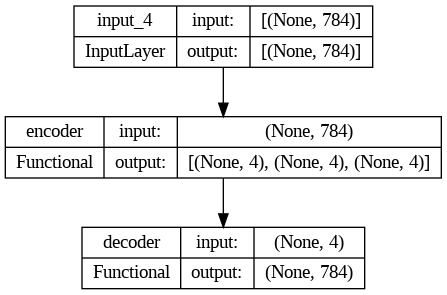

In [ ]:
tf.keras.utils.plot_model(vae03, show_shapes=True)

## Função de Custo

---



In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs03, outputs03)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma03 - K.square(z_mean03) - K.exp(z_log_sigma03)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae03.add_loss(vae_loss)

## Treinamento do Autoencoder

In [ ]:
vae03.compile(optimizer='adam')

history = vae03.fit(x_train, x_train,
                    epochs=200,
                    batch_size=256,
                    validation_data=(x_test, x_test),
                    verbose=0)

## Avaliação

313/313 [==============================] - 1s 2ms/step


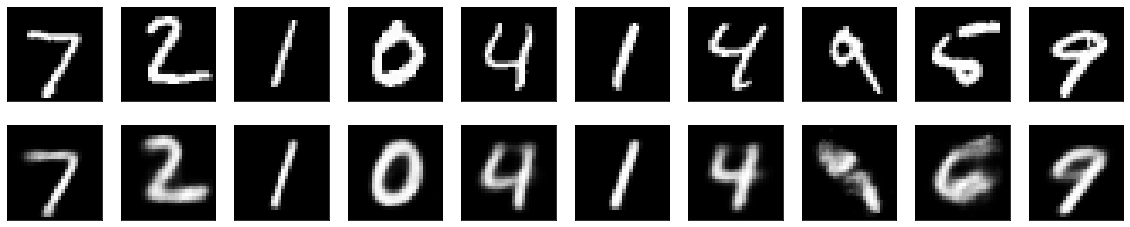

In [ ]:
decoded_imgs03 = vae03.predict(x_test)

n = 10  # Imagens visualizadas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrução
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs03[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

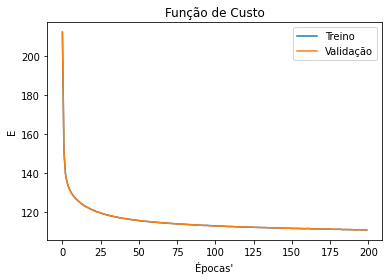

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()


### Visualização do Espaço Latente (como?)


40/40 [==============================] - 0s 2ms/step


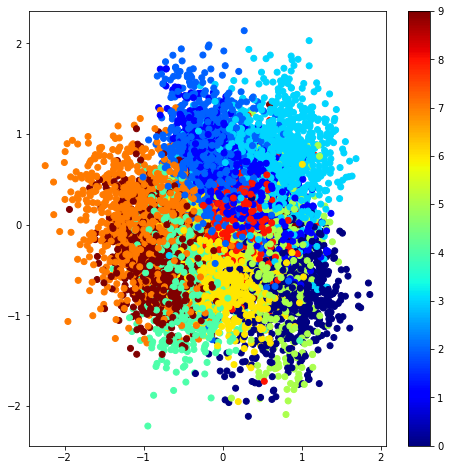

In [ ]:
x_test_encoded3 = encoder03.predict(x_test, batch_size=256)[2]

plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded3[:, 0], x_test_encoded3[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

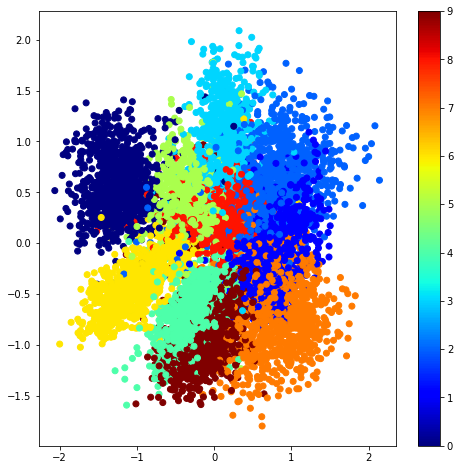

In [ ]:
# Modelo possui mais de duas dimensões: como visualizar?

plt.figure(figsize=(8, 8))
x_emb = PCA(n_components=2).fit_transform(x_test_encoded3)
plt.scatter(x_emb[:, 0], x_emb[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Exercício de Apoio

## Considerando os modelos VAE implementados acima, efetuar os seguintes experimentos:

- Utilizar técnicas de projeção, como a t-SNE e Kernel PCA para visualizar o espaço latente multidimensional gerado pelo VAE 
- Modificar a estrutura do VAE (hiperparâmetros) para melhorar a distribuição dos exemplos no espaço latente

Por fim, reporte os resultados no forum de discussão da semana




